<a href="https://colab.research.google.com/github/Esther-Wagatwe/Esther-Wagatwe/blob/main/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install isic-cli
!isic image download --limit 1000 myimages/

import pandas as pd
import os
import shutil

# Load metadata from the CSV file
metadata_path = 'myimages/metadata.csv'
metadata = pd.read_csv(metadata_path)

# Set the output directories
output_dir = 'myimages/'
benign = os.path.join(output_dir, 'benign')
malignant = os.path.join(output_dir, 'malignant')

# Create output directories if they don't exist
os.makedirs(benign, exist_ok=True)
os.makedirs(malignant, exist_ok=True)

# Iterate through the metadata and move images to the respective directories
for index, row in metadata.iterrows():
    image_name = row['isic_id'] + '.JPG'  # Assuming the image filenames are in the 'name' column
    source_path = os.path.join(output_dir, image_name)
    #print(f"Source File Exists: {os.path.exists(source_path)}")


    if row['benign_malignant'] == 'benign':
        target_dir = benign
    elif row['benign_malignant'] == 'malignant':
        target_dir = malignant
    else:
        continue  # Skip if the label is not 'benign' or 'malignant'

    target_path = os.path.join(target_dir, image_name)

    shutil.move(source_path, target_path)

# Print the number of images in each directory
print(f"Number of Benign Images: {len(os.listdir(benign))}")
print(f"Number of Malignant Images: {len(os.listdir(malignant))}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
Psst, you're logged out. Logging in with `isic user login` might return more data.


Successfully downloaded 1,000 images to myimages/.
Successfully wrote 1,000 metadata records to myimages/metadata.csv.
Successfully wrote attributions to myimages/attribution.txt.
Successfully wrote 2 license(s) to myimages/licenses.
Number of Benign Images: 755
Number of Malignant Images: 245


In [ ]:
!ls
!mv myimages/licenses/ .

licenses  myimages  sample_data


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Set directory paths
benign_dir = 'myimages/benign'
malignant_dir = 'myimages/malignant'

# Define image size and batch size
image_size = (224, 224)  # Adjust according to the model's input size
batch_size = 32

# Load the images and labels
dataset = tf.keras.utils.image_dataset_from_directory(
    'myimages/',
    labels='inferred',
    class_names=['benign', 'malignant'],
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
    seed=1337,
)

# Concatenate all batches to get the complete dataset
X, y = [], []
for batch_X, batch_y in dataset:
    X.append(batch_X.numpy())
    y.append(batch_y.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1337)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1337)


Found 1000 files belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocess images for the model
X_train_preprocessed = preprocess_input(X_train)
X_val_preprocessed = preprocess_input(X_val)
X_test_preprocessed = preprocess_input(X_test)

In [ ]:
!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub
import tensorflow.keras.layers


# Load the model from Kaggle
vit_model =hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/frameworks/TensorFlow2/variations/vit-b32-classification/versions/1")

# Create input layer
inputs = Input(shape=(224, 224, 3))

#Use the ViT model as a Keras layer
model = hub.KerasLayer(vit_model)(inputs)

# Add Dense layers on top of the ViT output
dense_layer_1 = Dense(256, activation='relu')(model)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)

output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_11 (KerasLayer  (None, 1000)              88224232  
 )                                                               
                                                                 
 dense_7 (Dense)             (None, 256)               256256    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 88513513 (337.65 MB)
Trainable params: 289281 (1.10 MB)
Non-trainable params: 88224232 (336.55 MB)
____________

In [ ]:
history = model.fit(X_train_preprocessed, y_train, epochs=10, validation_data=(X_val_preprocessed, y_val))


Epoch 1/10
19/19 [==============================] - 234s 12s/step - loss: 0.7577 - accuracy: 0.6750 - val_loss: 0.5156 - val_accuracy: 0.7450
Epoch 2/10
19/19 [==============================] - 135s 7s/step - loss: 0.5201 - accuracy: 0.7600 - val_loss: 0.5375 - val_accuracy: 0.7400
Epoch 3/10
19/19 [==============================] - 130s 7s/step - loss: 0.4698 - accuracy: 0.7900 - val_loss: 0.5967 - val_accuracy: 0.7400
Epoch 4/10
19/19 [==============================] - 129s 7s/step - loss: 0.4946 - accuracy: 0.7733 - val_loss: 0.4844 - val_accuracy: 0.7550
Epoch 5/10
19/19 [==============================] - 129s 7s/step - loss: 0.4409 - accuracy: 0.7917 - val_loss: 0.5022 - val_accuracy: 0.7600
Epoch 6/10
19/19 [==============================] - 129s 7s/step - loss: 0.4552 - accuracy: 0.7900 - val_loss: 0.4907 - val_accuracy: 0.7350
Epoch 7/10
19/19 [==============================] - 129s 7s/step - loss: 0.4472 - accuracy: 0.7933 - val_loss: 0.5137 - val_accuracy: 0.7500
Epoch 8/10
1

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

7/7 [==============================] - 30s 4s/step - loss: 0.5823 - accuracy: 0.7850
Test Accuracy: 78.50%
Test loss: 58.23%


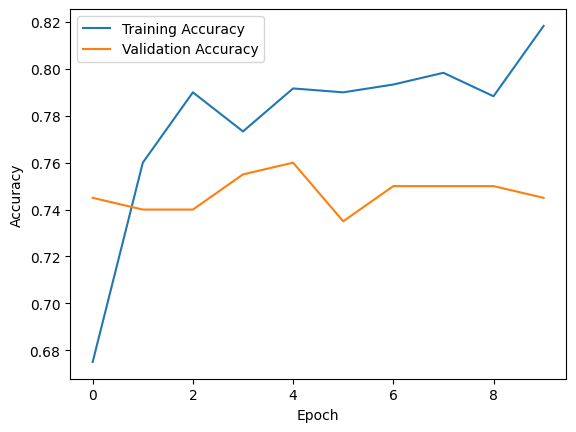

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


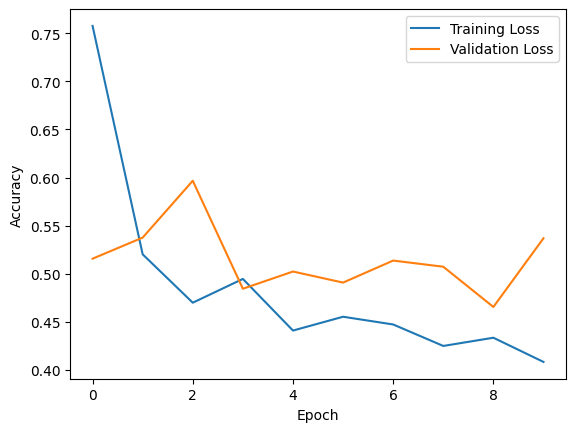

In [ ]:
# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
